https://matplotlib.org/users/image_tutorial.html

https://github.com/rohanchikorde/Data-Science-books/blob/master/Deep_Learning%20Books/Deep%20Learning%20with%20Keras%20by%20Antonio%20Gulli.pdf


https://medium.com/@mattiaspinelli/simple-generative-adversarial-network-gans-with-keras-1fe578e44a87
https://github.com/daymos/simple_keras_GAN

In [23]:
from google.colab import files
uploaded = files.upload()

In [0]:
import zipfile
zip_ref = zipfile.ZipFile('256x256maps.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [25]:
ls

256x256maps/     datalab/  requirements.txt
256x256maps.zip  images/   simple_gan_output.zip


In [0]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import cv2
from scipy import ndimage, misc
import os

In [6]:
mydata = []
for filename in os.listdir('256x256maps'):
    if filename.endswith(".png"): 
        img = mpimg.imread('256x256maps/' + filename)
        img = 255 - cv2.cvtColor( img, cv2.COLOR_RGB2GRAY )
        img = misc.imresize(img, (100,100))
        img = img.reshape([10000])
        mydata.append(img)
        continue
    else:
        continue

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [0]:
mydata = np.asarray(mydata)

In [8]:
mydata.shape
#Now each row represents an image and each column represents a pixel that takes a grayscale value between 0 and 

(908, 10000)

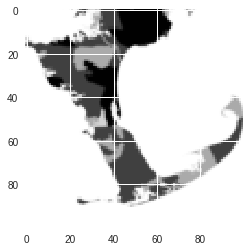

In [9]:
plt.imshow(mydata[3].reshape([100,100]))

https://medium.com/@mattiaspinelli/simple-generative-adversarial-network-gans-with-keras-1fe578e44a87

In [15]:
!pip install -r requirements.txt

    100% |████████████████████████████████| 81kB 2.6MB/s 
    100% |████████████████████████████████| 307kB 4.9MB/s 
    63% |████████████████████▍           | 10.8MB 12.7MB/s eta 0:00:01

    100% |████████████████████████████████| 16.9MB 1.2MB/s 
    100% |████████████████████████████████| 102kB 16.8MB/s 
    100% |████████████████████████████████| 61kB 18.0MB/s 
    100% |████████████████████████████████| 6.4MB 7.2MB/s 
    100% |████████████████████████████████| 849kB 12.1MB/s 
    100% |████████████████████████████████| 194kB 10.6MB/s 
    100% |████████████████████████████████| 512kB 13.5MB/s 
    28% |█████████▏                      | 13.3MB 24.5MB/s eta 0:00:02

    100% |████████████████████████████████| 46.7MB 509kB/s 
    100% |████████████████████████████████| 61kB 15.9MB/s 
    100% |████████████████████████████████| 44.4MB 742kB/s 
    100% |████████████████████████████████| 3.0MB 7.6MB/s 
  Running setup.py bdist_wheel for absl-py ... - done
  Stored in directory: /content/.cache/pip/wheels/34/67/31/e47fa35f2ece9669183e961e85479cc0b86de258b192ca1f2f
  Running setup.py bdist_wheel for scandir ... - \ done
  Stored in directory: /content/.cache/pip/wheels/d7/54/93/cbd031571c852fe58fddaf5631f67dc8d49b218c59519c7a39
  Running setup.py bdist_wheel for subprocess32 ... - \ done
  Stored in directory: /content/.cache/pip/wheels/31/d3/4d/8151bf3fba7d27d0c9d03b78d4ff16097a8b62b298dc937c8d
Successfully built absl-py scandir subprocess32
  Found existing installation: absl-py 0.2.0
    Uninstalling absl-py-0.2.0:
      Successfully uninstalled absl-py-0.2.0
  Found existing installation: backports.functools-lru-cache 1.5
    Uninstalling

    Uninstalling scipy-0.19.1:
      Successfully uninstalled scipy-0.19.1
  Found existing installation: Keras 2.1.6
    Uninstalling Keras-2.1.6:
      Successfully uninstalled Keras-2.1.6
  Found existing installation: scandir 1.7
    Uninstalling scandir-1.7:
      Successfully uninstalled scandir-1.7
  Found existing installation: pathlib2 2.3.2
    Uninstalling pathlib2-2.3.2:
      Successfully uninstalled pathlib2-2.3.2
  Found existing installation: pbr 4.0.2
    Uninstalling pbr-4.0.2:
      Successfully uninstalled pbr-4.0.2
  Found existing installation: pexpect 4.5.0
    Uninstalling pexpect-4.5.0:
      Successfully uninstalled pexpect-4.5.0
  Found existing installation: protobuf 3.5.2.post1
    Uninstalling protobuf-3.5.2.post1:
      Successfully uninstalled protobuf-3.5.2.post1
  Found existing installation: Pygments 2.1.3
    Uninstalling Pygments-2.1.3:
      Successfully uninstalled Pygments-2.1.3
  Found existing installation: python-dateutil 2.5.3
    Uninstallin

In [7]:
import os
os.makedirs('images')

OSError: ignored

In [12]:
import numpy as np

from IPython.core.debugger import Tracer

#from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

import matplotlib.pyplot as plt
plt.switch_backend('agg')   # allows code to run without a system DISPLAY


class GAN(object):
    """ Generative Adversarial Network class """
    def __init__(self, width=100, height=100, channels=1):

        self.width = width
        self.height = height
        self.channels = channels

        self.shape = (self.width, self.height, self.channels)

        self.optimizer = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)

        self.G = self.__generator()
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer)

        self.D = self.__discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])

        self.stacked_generator_discriminator = self.__stacked_generator_discriminator()

        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)


    def __generator(self):
        """ Declare generator """

        model = Sequential()
        model.add(Dense(256, input_shape=(100,)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.width  * self.height * self.channels, activation='tanh'))
        model.add(Reshape((self.width, self.height, self.channels)))

        return model

    def __discriminator(self):
        """ Declare discriminator """

        model = Sequential()
        model.add(Flatten(input_shape=self.shape))
        model.add(Dense((int(self.width * self.height * self.channels)), input_shape=self.shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense((int((self.width * self.height * self.channels)/2))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        return model

    def __stacked_generator_discriminator(self):

        self.D.trainable = False

        model = Sequential()
        model.add(self.G)
        model.add(self.D)

        return model

    def train(self, X_train, epochs=201, batch = 32, save_interval = 10):

        for cnt in range(epochs):

            ## train discriminator
            random_index = np.random.randint(0, len(X_train) - batch/2)
            legit_images = X_train[int(random_index) : int(random_index + batch//2)].reshape(batch//2, self.width, self.height, self.channels)

            gen_noise = np.random.normal(0, 1, (batch//2, 100))
            syntetic_images = self.G.predict(gen_noise)

            x_combined_batch = np.concatenate((legit_images, syntetic_images))
            y_combined_batch = np.concatenate((np.ones((batch/2, 1)), np.zeros((batch/2, 1))))

            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)


            # train generator

            noise = np.random.normal(0, 1, (batch, 100))
            y_mislabled = np.ones((batch, 1))

            g_loss = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)

            print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss))

            if cnt % save_interval == 0:
                self.plot_images(save2file=True, step=cnt)


    def plot_images(self, save2file=False, samples=16, step=0):
        ''' Plot and generated images '''
        filename = "images/maps_%d.png" % step
        noise = np.random.normal(0, 1, (samples, 100))

        images = self.G.predict(noise)

        plt.figure(figsize=(10, 10))
        
        for i in range(images.shape[0]):
          image = images[i,:,:,:]
          image = np.reshape(image, [self.height, self.width])
          plt.imshow(image)
        
        #for i in range(images.shape[0]):
            #plt.subplot(4, 4, i+1)
            #plt.subplot(1, 1, i+1)
            #image = images[i, :, :, :]
            #image = np.reshape(image, [self.height, self.width])
            #plt.imshow(image, cmap='gray')
            #plt.imshow(image)
            #plt.axis('off')
        plt.tight_layout()

        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()


if __name__ == '__main__':
    # (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = (mydata.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)


    gan = GAN()
    gan.train(X_train)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 10000)             100010000 
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 10000)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 5000)              50005000  
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 5000)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 5001      
Total params: 150,020,001
Trainable params: 150,020,001
Non-trainable params: 0
______________________________________________________________

epoch: 37, [Discriminator :: d_loss: 8.059048], [ Generator :: loss: 14.861616]
epoch: 38, [Discriminator :: d_loss: 7.294455], [ Generator :: loss: 14.607023]
epoch: 39, [Discriminator :: d_loss: 7.544423], [ Generator :: loss: 13.095976]
epoch: 40, [Discriminator :: d_loss: 8.433771], [ Generator :: loss: 14.638198]
epoch: 41, [Discriminator :: d_loss: 7.555360], [ Generator :: loss: 15.526659]
epoch: 42, [Discriminator :: d_loss: 7.830024], [ Generator :: loss: 15.525492]
epoch: 43, [Discriminator :: d_loss: 7.853681], [ Generator :: loss: 15.171833]
epoch: 44, [Discriminator :: d_loss: 7.100206], [ Generator :: loss: 15.047208]
epoch: 45, [Discriminator :: d_loss: 7.936990], [ Generator :: loss: 15.614405]
epoch: 46, [Discriminator :: d_loss: 8.397877], [ Generator :: loss: 15.764191]
epoch: 47, [Discriminator :: d_loss: 6.987127], [ Generator :: loss: 11.949937]
epoch: 48, [Discriminator :: d_loss: 3.053765], [ Generator :: loss: 12.088572]
epoch: 49, [Discriminator :: d_loss: 2.3

epoch: 86, [Discriminator :: d_loss: 4.987486], [ Generator :: loss: 8.059048]
epoch: 87, [Discriminator :: d_loss: 4.998467], [ Generator :: loss: 8.908289]
epoch: 88, [Discriminator :: d_loss: 5.000255], [ Generator :: loss: 8.562738]
epoch: 89, [Discriminator :: d_loss: 4.489286], [ Generator :: loss: 8.562739]
epoch: 90, [Discriminator :: d_loss: 1.992803], [ Generator :: loss: 9.308077]
epoch: 91, [Discriminator :: d_loss: 4.998468], [ Generator :: loss: 9.066429]
epoch: 92, [Discriminator :: d_loss: 5.994867], [ Generator :: loss: 9.066429]
epoch: 93, [Discriminator :: d_loss: 4.500268], [ Generator :: loss: 7.555357]
epoch: 94, [Discriminator :: d_loss: 1.980734], [ Generator :: loss: 8.332739]
epoch: 95, [Discriminator :: d_loss: 4.381424], [ Generator :: loss: 8.045871]
epoch: 96, [Discriminator :: d_loss: 4.987494], [ Generator :: loss: 9.066429]
epoch: 97, [Discriminator :: d_loss: 3.991087], [ Generator :: loss: 9.066429]
epoch: 98, [Discriminator :: d_loss: 4.992977], [ Ge

epoch: 135, [Discriminator :: d_loss: 4.992977], [ Generator :: loss: 7.555357]
epoch: 136, [Discriminator :: d_loss: 6.493066], [ Generator :: loss: 7.555357]
epoch: 137, [Discriminator :: d_loss: 3.996578], [ Generator :: loss: 6.776927]
epoch: 138, [Discriminator :: d_loss: 3.492887], [ Generator :: loss: 7.051667]
epoch: 139, [Discriminator :: d_loss: 3.487399], [ Generator :: loss: 8.059048]
epoch: 140, [Discriminator :: d_loss: 3.991087], [ Generator :: loss: 6.547976]
epoch: 141, [Discriminator :: d_loss: 4.489287], [ Generator :: loss: 7.555357]
epoch: 142, [Discriminator :: d_loss: 3.487397], [ Generator :: loss: 8.562738]
epoch: 143, [Discriminator :: d_loss: 4.035696], [ Generator :: loss: 8.562738]
epoch: 144, [Discriminator :: d_loss: 6.493067], [ Generator :: loss: 8.562738]
epoch: 145, [Discriminator :: d_loss: 6.980284], [ Generator :: loss: 8.562738]
epoch: 146, [Discriminator :: d_loss: 4.992977], [ Generator :: loss: 8.059048]
epoch: 147, [Discriminator :: d_loss: 3.

epoch: 184, [Discriminator :: d_loss: 4.992977], [ Generator :: loss: 6.938886]
epoch: 185, [Discriminator :: d_loss: 3.985596], [ Generator :: loss: 7.051667]
epoch: 186, [Discriminator :: d_loss: 2.490998], [ Generator :: loss: 7.555357]
epoch: 187, [Discriminator :: d_loss: 5.485686], [ Generator :: loss: 7.051667]
epoch: 188, [Discriminator :: d_loss: 3.991087], [ Generator :: loss: 6.547976]
epoch: 189, [Discriminator :: d_loss: 5.485686], [ Generator :: loss: 7.051667]
epoch: 190, [Discriminator :: d_loss: 3.991087], [ Generator :: loss: 7.611899]
epoch: 191, [Discriminator :: d_loss: 6.482085], [ Generator :: loss: 7.555357]
epoch: 192, [Discriminator :: d_loss: 5.983885], [ Generator :: loss: 8.059048]
epoch: 193, [Discriminator :: d_loss: 3.985596], [ Generator :: loss: 7.051719]
epoch: 194, [Discriminator :: d_loss: 1.494599], [ Generator :: loss: 6.716700]
epoch: 195, [Discriminator :: d_loss: 1.992798], [ Generator :: loss: 6.547976]
epoch: 196, [Discriminator :: d_loss: 3.

In [13]:
cd images

/content/images


In [14]:
ls

maps_0.png    maps_130.png  maps_180.png  maps_40.png  maps_90.png
maps_100.png  maps_140.png  maps_190.png  maps_50.png
maps_10.png   maps_150.png  maps_200.png  maps_60.png
maps_110.png  maps_160.png  maps_20.png   maps_70.png
maps_120.png  maps_170.png  maps_30.png   maps_80.png


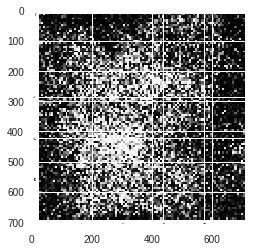

In [20]:
imgplot = plt.imshow(mpimg.imread('maps_150.png'))

In [21]:
cd ~

/content


In [22]:
import shutil
shutil.make_archive('simple_gan_output', 'zip', 'images')

'/content/simple_gan_output.zip'

In [0]:
from google.colab import files
files.download('simple_gan_output.zip')

In [14]:
cd ~

/content
